# Grafs per estudiar una xarxa

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import random

In [3]:
from tqdm import tqdm_notebook # pip install --user tqdm

## Definició d'un graf

Hi ha xarxes que es representen com un grafs $G$, que és una entitat matemàtica formada per un conjunt no buit $V$ d’elements que anomenem **vèrtexs, punts o nodes** i una col·lecció $E$ de parelles desordenades de vèrtexs que anomenem **arestes** o enllaços i que simbòlicament es representa com $G = (V, E)$. 
El nombre de nodes representa la **mida de la xarxa**.

En general ens referim a un vèrtex particular pel seu ordre $i$ en el conjunt $V$ i els seus dos vèrtexs, $i$ i $j$, rebran el nom d’**adjacents** (o connectats) si existeix l’aresta $(i, j)$ que els uneix.

In [4]:
# Comprovem que tot el necessari estigui instal·lat
if __name__ == '__main__':
    import re

    def cmp(version1, version2):
        def normalize(v):
            return [int(x) for x in re.sub(r'(\.0+)*$','', v).split(".")]
        a,b = (normalize(version1), normalize(version2))
        return (a > b) - (a < b)

    try:
        import yaml
        if cmp(yaml.__version__, '5.1') < 0:
            raise NotImplementedError()
    except:
        print('YAML no trobat o massa antic')
        if input('Vols instalar YAML? [s/n]').strip().lower() == 's':
            !pip3 install --user -U PyYAML
            !pip install --user -U PyYAML
        else:
            print('Abans de continuar instal·la YAML')

    try:
        import networkx as nx
        if cmp(nx.__version__, '2.4') < 0:
            raise NotImplementedError()
    except:
        print('Networkx no trobat o massa antic')
        if input('Vols instalar Networkx? [s/n]').strip().lower() == 's':
            !pip3 install --user -U networkx==2.4
            !pip install --user -U networkx==2.4
        else:
            print('Abans de continuar instal·la Networkx')

**Lectura del graf a partir de la llibreria networkx**

In [5]:
# Lectura del graf
G = nx.readwrite.read_yaml('data/graph.yml')

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4525
Number of edges: 6107
Average degree:   2.6992


## Breu explicació del graf

Durant aquest lliurament treballarem amb el graf obtingut de les linies de busos que circulen per l'Àrea Mertropolitana de Barcelona.

Els nodes d'aquest graf estan representats per les coodernades que ocupa cada estació.

Cada aresta té els atributs dist i color. 
A la pràctica necesitarem utiltizar l'atribut 'dist' per tal de tenir en compte les distàncies entre estacions, i el color representarà la línia.

```python
    (node_i, node_j) : {'color': color, 'dist': distancia}

```

In [6]:
list(G.edges.data())[0]

((41.26251865, 1.93088592),
 (41.26339831, 1.93551593),
 {'color': (0.0, 0.9918427367542761, 0.24580818269582871, 1.0),
  'dist': 399.984062636331})

Abans de començar a analitzar la xarxa de busos de l'àrea metropolitana de Barcelona, anem a visualitzar aquesta xarxa.

In [7]:
def plot_gragh(G, scores=None, use_colors=True):
    """
    Funció que visualitza el graf de les estacions de tren a sobre de Barcelona.
    """
    fig = plt.figure(figsize=(16, 10), constrained_layout=True)
    ax = fig.gca()
    plt.axis('off')
    
    if scores is not None:
        spec = GridSpec(ncols=2, nrows=1, width_ratios=[2, 1], height_ratios=[1], figure=fig)
        ax = plt.subplot(spec[0, 0])
    
    pos = {n: np.asarray(n) for n in G.nodes}
    colors = 'black' if not use_colors else [G.edges[e]['color'] for e in G.edges]
    
    nx.draw_networkx_edges(
        G, 
        pos=pos,
        edge_color=colors
    )
    
    apos = np.asarray(list(pos.values()))
    minx = apos.min(axis=0)
    maxx = apos.max(axis=0)
    ax.set_xlim([minx[0], maxx[0]])
    ax.set_ylim([minx[1], maxx[1]])

    if scores is not None:
        nodelist = sorted(G.nodes(), key=lambda n: scores[n])
        ncolor = np.asarray([scores[n] for n in nodelist])
        nodes = nx.draw_networkx_nodes(G, nodelist=nodelist, pos=pos, node_size=20, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
        plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

        plt.subplot(spec[0, 1])
        score_array = np.array(list(scores.values()))
        plt.hist(score_array,bins=100)
        plt.show() 

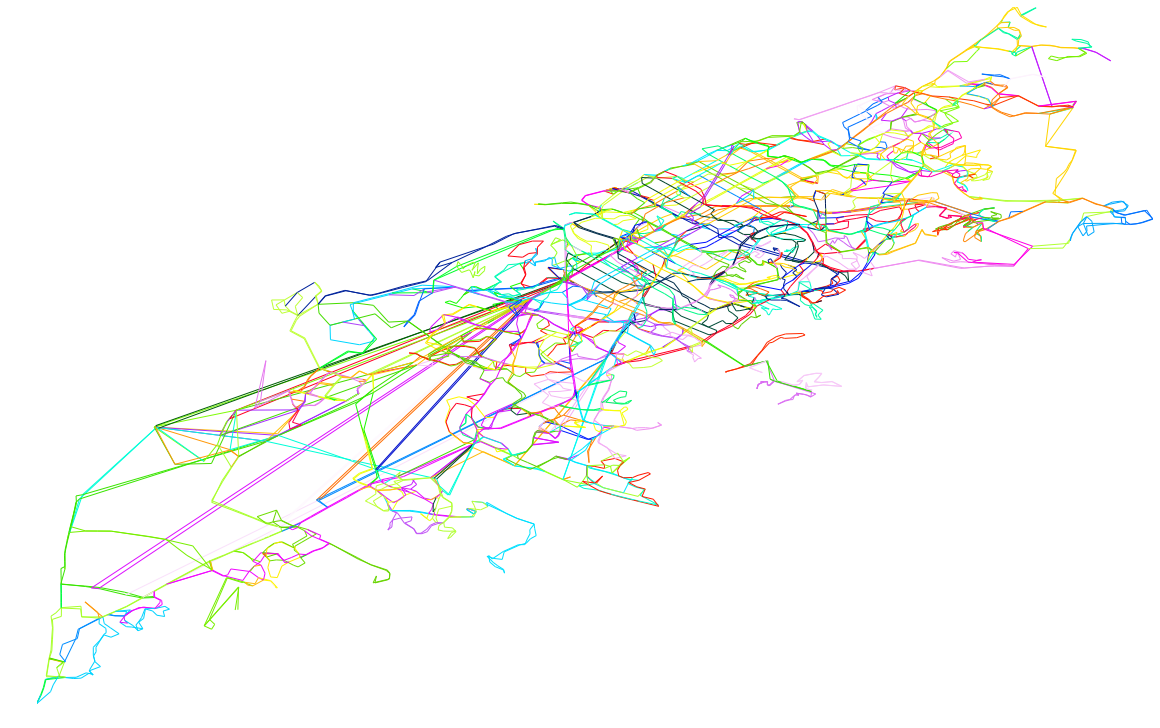

In [8]:
plot_gragh(G)

## Matriu d’Adjacència

Un graf es pot representar per la seva corresponent **matriu d’adjacència** $A = {a_{ij}}$ que, en el cas més simple, serà una matriu simètrica de $V \times V$ elements.

L’element $a_{ij}$ de la matriu $A$ prendrà com a valor $1$ si l’aresta $(i, j)$ pertany a $E$, i $0$ en qualsevol altra cas.

La matriu és simètrica si existeix una aresta que uneix $i$ amb $j$ i també existeix l’aresta que connecti $j$ amb $i$. Llavors $a_{ij}$ = $a_{ji}$.

Les arestes d’una xarxa poden ser també **dirigides** (quan apunten una direcció determinada de l’enllaç entre els dos vèrtexs), **múltiples** (quan més d’una aresta connecta els mateixos nodes), **autoarestes** (quan surten de i arriben a un mateix node) i molts altres tipus diferents que es poden introduir a mesura que la correcta definició d’una xarxa així ho requereixi.

In [87]:
def matriu_adjacencia(G):
    """
    Funció que calcula la matriu adjacent del graf G.
    Per tal d'obtenir els nodes podeu utilizar les funcions:
        - G.nodes per obtenir els nodes.
        - G.edges per obtenir les parelles de nodes.
        
    :param G: graf G
    :return: np.array, la matriu d'adjacència
    """
    # List and number of nodes in G.
    nodes, nnodes = list(G.nodes), len(G.nodes)
        
    # Empty matrix and indexes of lower matrix.
    matrix = np.zeros((nnodes, nnodes))
    #u, l  = np.tril_indices(nnodes, k=-1), np.triu_indices(nnodes, k=+1)
    # Inefficient nested loop for computing adjacency matrix, but there's no way around it while keeping
    # the correct adjacency matrix.
    for i in range(nnodes):
            #matrix[i, j] = matrix[j + i + 1, -i + nnodes - 1] = 1 if (nodes[i], nodes[j]) in G.edges else 0
        matrix[i] = [1 if (nodes[i], nodes[j]) in G.edges else 0 for j in range(nnodes)]
    #matrix[l] = np.flipud(np.fliplr(matrix))[l]
    return matrix

In [10]:
adj_matrix = matriu_adjacencia(G)
adj_matrix

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
np.unique(nx.linalg.graphmatrix.adjacency_matrix(Gr).toarray(), return_counts=True)

(array([0, 1], dtype=int32), array([12983,   242], dtype=int64))

In [92]:
np.unique(adj_matrix2, return_counts=True)

(array([0., 1.]), array([12983,   242], dtype=int64))

# Longitud de camí característic

Una de les mesures globals tradicionalment més utilitzades per caracteritzar una xarxa ha estat la de la **longitud de camí característic L**.


Aquest concepte deriva del de *camí d’una xarxa*, que es defineix com la seqüència de nodes que, units per arestes, porten del node $i$ al node $j$. 
La longitud de camí característic es defineix com la mitja dels *camins més curts* calculada per totes les parelles de nodes de la xarxa:

$$L(G) = \frac{1}{N(N-1)} \sum_{i\neq j \in N}l_{ij} = \frac{2}{N(N-1)} \sum_{i>j} l_{ij}
$$

on el camí més curt $l_{ij}$ , en termes d’arestes utilitzades per anar del node i al node j, rep també el nom de camí geodèsic.


In [15]:
def random_subgraph(G, p=0.8):
    """
    Funció que genera un subgraf del graf donat.
    """
    linies = set(G.nodes[n]['IdLinia'] for n in G.nodes)
    linies = set(random.sample(linies, int(len(linies) * p)))
    nodes = [n for n in G.nodes if G.nodes[n]['IdLinia'] in linies]
    Gr = nx.subgraph(G, nodes)
    Gr = max((G.subgraph(c) for c in nx.connected_components(Gr)), key=len)
    return Gr

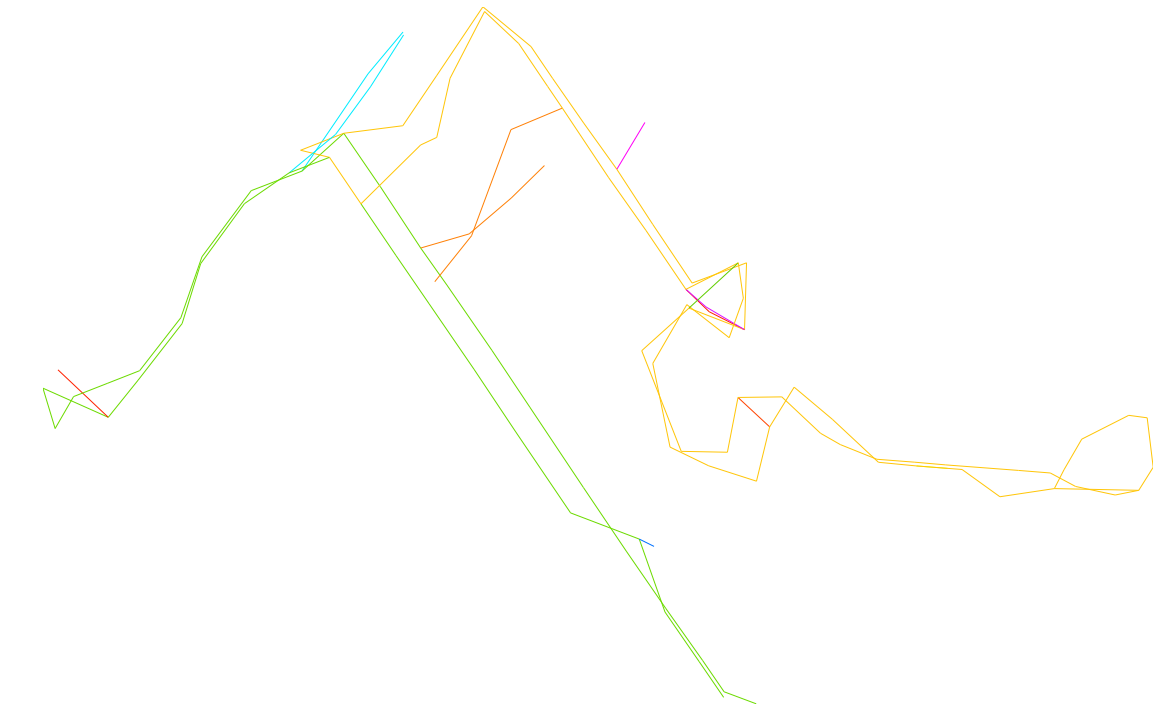

In [16]:
Gr = random_subgraph(G, 0.2)
plot_gragh(Gr)

In [17]:
def longitud_cami_caracteristic(G):
    """
    Funció que calcula la longitud del camí característic.
    
    Per calcular els camins mínims entre dos nodes podeu utilizar la funció:
        - nx.shortest_path_length(graf, node_i, node_j, 'dist')
    
    :param G: graf de la xarxa
    :return: Longitud de camí característic, float
    """
    # List and number of nodes in G. Abbreviation of nx function.
    nodes, nnodes, fun = list(G.nodes), len(G.nodes), nx.shortest_path_length
    # All shortests paths between all nodes in the graph, excluding cycles.
    shortest_paths = [fun(G, nodes[i], nodes[j], 'dist') for i in range(nnodes) for j in range(nnodes) if i != j]
    
    # Return mean of all shortest paths.
    return np.mean(shortest_paths)

In [18]:
nx.average_shortest_path_length(Gr, 'dist')

4956.496708167079

In [19]:
longitud_cami_caracteristic(Gr)

4956.496708167048

Defnim el **diametre** d'un graf com el cami més llarg entre dos nodes.

In [20]:
def diametre(G):
    """
    Funció que calcula el diametre de la xarxa.
    Per calcular els camins mínims entre dos nodes podeu utilizar la funció:
        - nx.shortest_path_length(graf, node_i, node_j, 'dist')
    :param G: graf de la xarxa
    :return: diametre, float
    """
    # List and number of nodes in G. Abbreviation of nx function.
    nodes, nnodes, fun = list(G.nodes), len(G.nodes), nx.shortest_path_length
    # All shortests paths between all nodes in the graph, excluding cycles.
    shortest_paths = [fun(G, nodes[i], nodes[j], 'dist') for i in range(nnodes) for j in range(nnodes) if i != j]
    
    # Return mean of all shortest paths.
    return sorted(shortest_paths, reverse=True)[0]

In [21]:
diametre(Gr)

13070.135473126553

# Grau d'un node

Una mesura local útil per caracteritzar una xarxa és la de **grau d’un node**, definit pel nombre d’arestes que s’hi connecten i que enllacen, a la vegada, amb els nodes primers veïns. De forma matemàtica, el grau $k_i$ d’un node $i$ és

$$ k_i = \sum_{j\in N} a_{ij}
$$

A partir d’ella podem calcular la distribució estadística del grau en una xarxa, això és la distribució de grau. Si definim $p_k$ com la fracció de nodes d’una xarxa G que tenen grau $k$, $p_k$ serà, al mateix temps, la probabilitat que un node escollit aleatòriament tingui un grau $k$.



In [93]:
def grau_node(adj_matrix):
    """
    Funció que calcula el grau de cada node a partir de la matriu adjacent.
    
    :param adj_matrix: matriu d'ajacencia del graf
    :return : vector amb on a la posició i es troba el grau del node i
    """
    # Summatory of the adjacency matrix rows is the node's degree.
    return np.sum(adj_matrix, axis=1)

In [24]:
def nodes_per_grau(graus):
    """
    Funció que retorna un dictionari amb el grau del node i quanitat d'ells que el tenen.
    
    :param graus: vector que retorna la funció grau_node
    :return : diccionari esmentat 
    """
    # With numpy's unique function all degrees and its counts are gathered.
    degrees, counts = np.unique(graus, return_counts=True)

    # The values are zipped and returned in a dictionary where key: degree and value: #nodes
    return dict(zip(degrees, counts))

degree_dic = nodes_per_grau(grau_node(adj_matrix))

In [25]:
degree_hist = pd.DataFrame({"degree": list(degree_dic.values()),
                            "Number of Nodes": list(degree_dic.keys())})

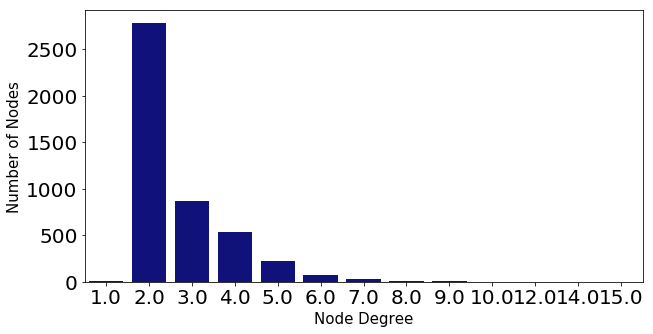

In [26]:
plt.figure(figsize=(10,5))
sns.barplot(y = 'degree', x = 'Number of Nodes', 
              data = degree_hist, 
              color = 'darkblue')
plt.xlabel('Node Degree', fontsize=15)
plt.ylabel('Number of Nodes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

<hr />

* RECORDA JUSTIFICAR LA RESPOSTA

<hr />

**Que representa aquesta gràfica? Té sentit aquesta distribució?**

Aquesta gràfica representa tots els graus dels vèrtexs i la quantitat de nodes que tenen cada grau. Si que té sentit, doncs el graf representa la xarxa de l'AMB, on la majoria de parades són intermitjes (grau 2) i les parades acostumen a tenir tres o quatre transbordaments com a molt (si en tenen). També les estacions de grau 1 poden correspondre a inicis i finals de línies, poques en comparació amb la resta de parades o a rutes circulars, on l'inici coincideix amb el final.

# Densitat

Tenint en compte el nombre de nodes i d'arestes podem saber quina és l’estructura de la xarxa. Una mesura de l'estructura d'una xarxa és l'anomenada **densitat** que mesura la quanitat d'enllaços respecte tots els possibles que hi ha definits dins de la xarxa. La densitat és $0$ si no hi ha arestes, s'anomena **gràfic buit** i $1$ si tenim un **gràfic complet**, s'estableixen tots els enllaços possibles entre nodes.

$$dens_{undirected} = \frac{2E}{N(N-1)}$$

$$dens_{directed} = \frac{E}{N(N-1)}$$


In [27]:
def densitat(G):
    """
    Funció que calcula la densitat del graf
    
    :param G: graf
    :return : densitat del graf, float
    """
    # Number of nodes and edges.
    nnodes, nedges = len(G.nodes), len(G.edges)    
    
    # Density for directed graph.
    if nx.is_directed(G): return (nedges/(nnodes*(nnodes - 1)))
    
    # Density of undirected graph.
    return (2*nedges)/(nnodes*(nnodes - 1))

In [28]:
densitat(G)

0.0005966460033901451

In [29]:
nx.density(G)

0.0005966460033901451

<hr />

* RECORDA JUSTIFICAR LA RESPOSTA

<hr />

**Té sentit aquest valor?**
Si que té sentit ja que la densitat mesura la quantitat d'enllaços entre tots els possibles, i el graf G només té enllaços entre nodes d'una mateixa línia o en els transbordaments. Està llavors lluny d'un graf complet (densitat 1) i d'un graf buit amb densitat 0. 


# Mitjana (betweenness)

L’anomenada **mitjana d’un node** sorgeix al comprovar com la relació existent entre dos nodes no adjacents pot dependre d’un tercer, especialment si aquest es troba en el camí d’unió dels dos primers.

En conseqüència, els nodes existents en els camins d’unió entre d’altres, poden exercir una influència notable i un control estratègic sobre la resta.

Assumint que un element és important si es troba enmig de la resta d’elements i que la informació (o qualsevol altre producte) viatja tan sols a través de camins geodèsics, si $n_{jk}$ és el nombre de **camins geodèsics** (o més curts) que uneixen els dos vèrtexs $j$ i $k$, i $n_{jk}(i)$ és el nombre de camins geodèsics que uneixen els vèrtexs $j$ i $k$ que contenen el vèrtex $i$, la mitjania del vèrtex $i$ es pot definir com

$$ C^B_i = \frac{1}{(N − 1)(N − 2)} \sum_{j,k\in N} \frac{n_{jk}(i)}{n_{jk}}
$$

on $N$ és el nombre de nodes de la xarxa (utilitzats a l’equació anterior a efectes normalitzadors). $C^B$ pren valors entre $0$ i $1$, essent igual a $1$ en el cas que el vèrtex i estigui present en tots els camins geodèsics del graf.

In [95]:
def mitjana(G, i):
    """
    Funció que calcaula la mitjana d'un node.
    
    Per calcular els camins mínims entre dos nodes podeu utilizar la funció:
        - nx.all_shortest_paths(graf, node_i, node_j, 'dist')
        
    :param G: graf
    :param i: float, mijana pel vertex i
    """
    nodes, fun = list(G.nodes), nx.all_shortest_paths
    #nodes.remove(i)
    nnodes = len(nodes)
    
    contained = lambda n: 1 if i in n else 0
    # All shortest paths between all node in the graph.
    sp = [[*fun(G, nodes[k], nodes[j], 'dist')] for k in range(nnodes) for j in range(nnodes)]
    # Number of geodesic paths for every node.
    n = [len(j) for j in sp]
    # Number of geodesic paths for every node, that contain node 'i'.
    ni = [np.sum([contained(n_path) for n_path in node]) for node in sp]

    div = np.sum([ni[j]/n[j] for j in range(len(n))])
    
    return (1/((nnodes - 1)*(nnodes - 2)))*div

mitjana(Gr, next(iter(Gr.nodes)))

0.3535941623971433

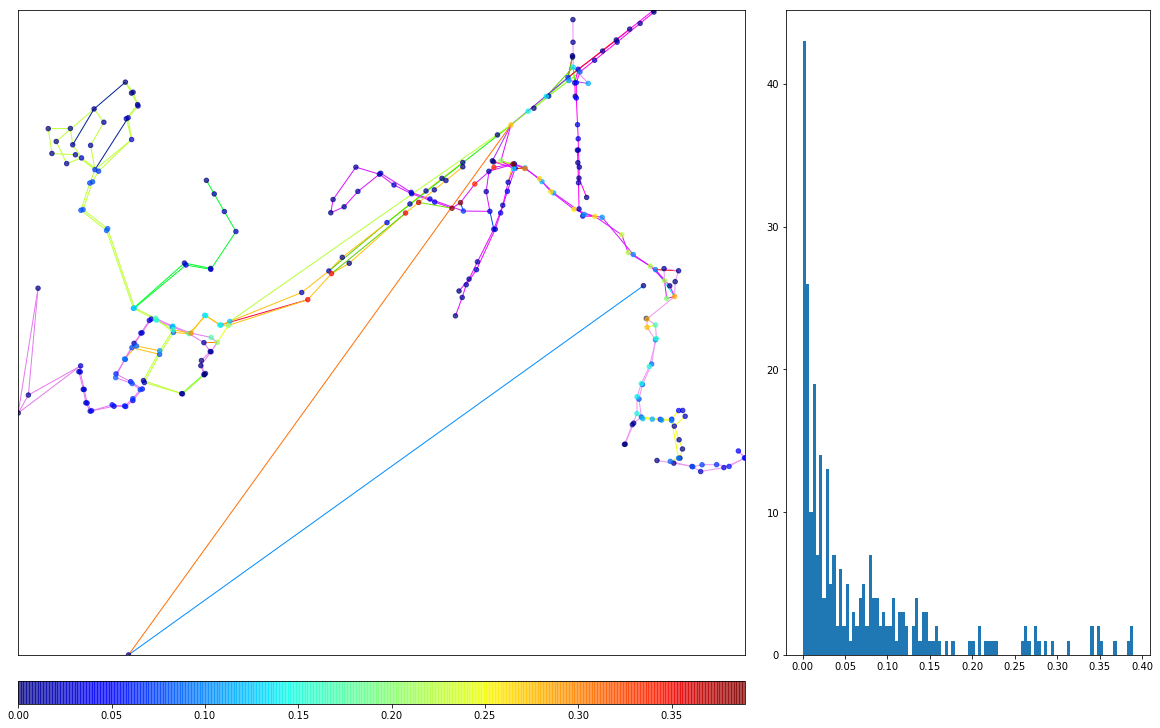

In [142]:
betweenness_centrality = nx.betweenness_centrality(Gr, weight='dist')
plot_gragh(Gr, dict(betweenness_centrality))

# Mesura de centralitat

Les mesures de centralitat mesuren la posició d’un actor en una xarxa segons uns certs criteris.

La **centralitat de grau d’un actor** és la més simple de les mesures i es calcula com el nombre dels veins que té entre el total de nodes del graf.

Hi ha gent, la posició favorable de la qual a la xarxa els hi permet ser els iniciadors de processos d’influència com la transmissió de creences, publicitat viral, etc. En aquest cas, el procés comença en un actor i es va transmetent successivament. Una mesura de centralitat que mesuri això ha d’estar basada en contar camins.


In [30]:
def centralitat(G, n):
    """
    Funció que mesura la centralitat del veï n al graf G
    
    :param G: graf
    :param n: node
    :return : float, mesura de centralitat del node n
    """
    # Number of neighbours of node in graph G by number of nodes in Graph.
    return len(list(G.neighbors(n)))/len(G.nodes)

centralitat_grau = {node: centralitat(G, node) for node in G.nodes}
nx_centrality = nx.degree_centrality(G)

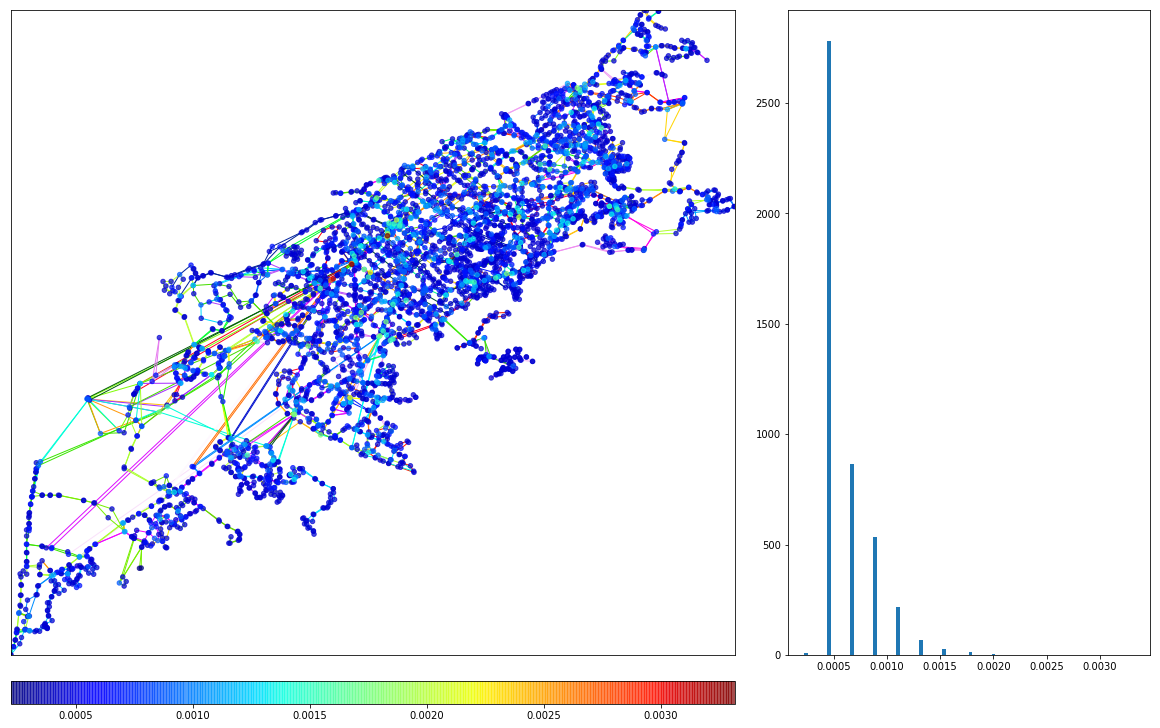

In [175]:
plot_gragh(G, dict(nx_centrality))

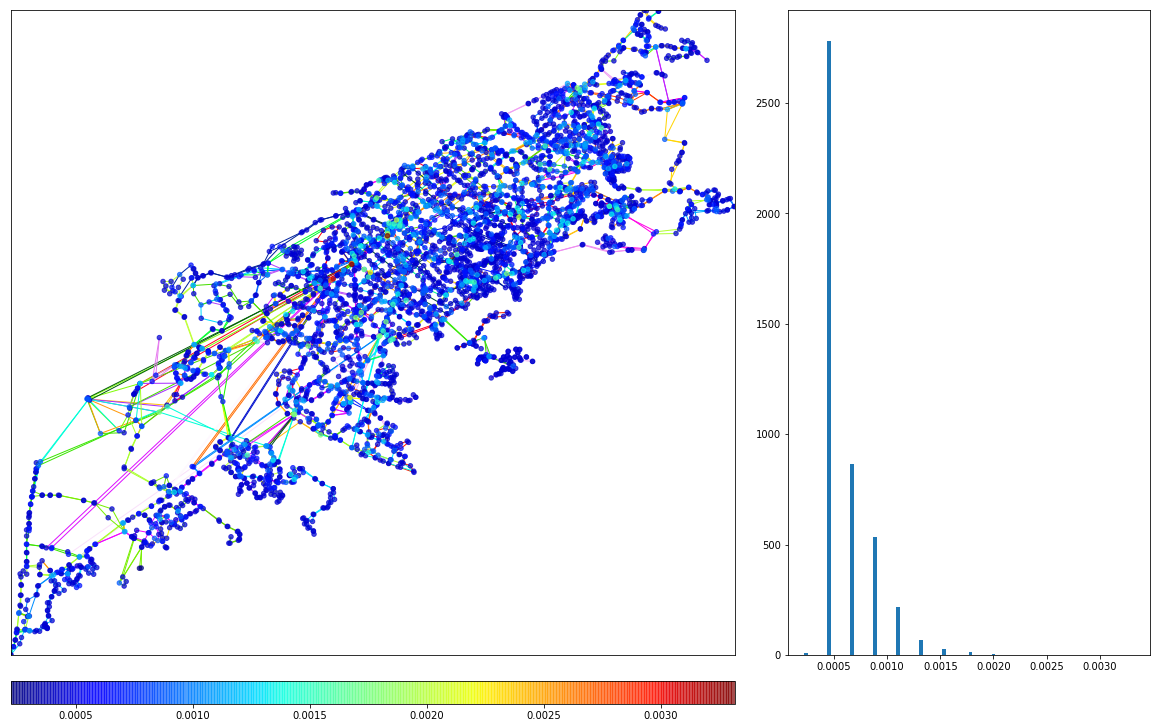

In [179]:
plot_gragh(G, centralitat_grau)

Una altra mesura de posició surt de considerar la distància mitja de cada node a la resta de la xarxa: l’actor que està més a prop de tot altre element de la xarxa és el més central. 

Aquesta mesura és diu **centralitat de rodalies**. Matemàticament, es pot expressar com la inversa de la suma de les distàncies 
$$ c_i = \frac{1}{\sum_j d_{ij}}$$
on $d_{ij}$ és la distància entre l'actor $i$ i l'actor $j$.


In [31]:
def centralitat_rodalies(G, n):
    """
    Funció que calcula la centralitat de rodalies per un node donat.
    
    Per calcular els camins mínims entre dos nodes podeu utilizar la funció:
        - nx.shortest_path_length(graf, node_i, node_j, 'dist')
        
    :param G: graf
    :param n: node
    :return : float, centralitat de rodalies del node n  
    """
    nodes, fun = list(G.nodes), nx.shortest_path_length
    # Shortest distance from n to each node of G.
    sp = [fun(G, n, i, 'dist') for i in nodes]

    return 1/np.sum(sp)

In [42]:
centralitat_rodalies(Gr, next(iter(Gr.nodes)))
#centralitat_rodalies(G, next(iter(G.nodes)))

2.6372659916217515e-06

In [31]:
load_centrality = nx.load_centrality(Gr, weight='dist')
#load_centrality = nx.load_centrality(G, weight='dist')

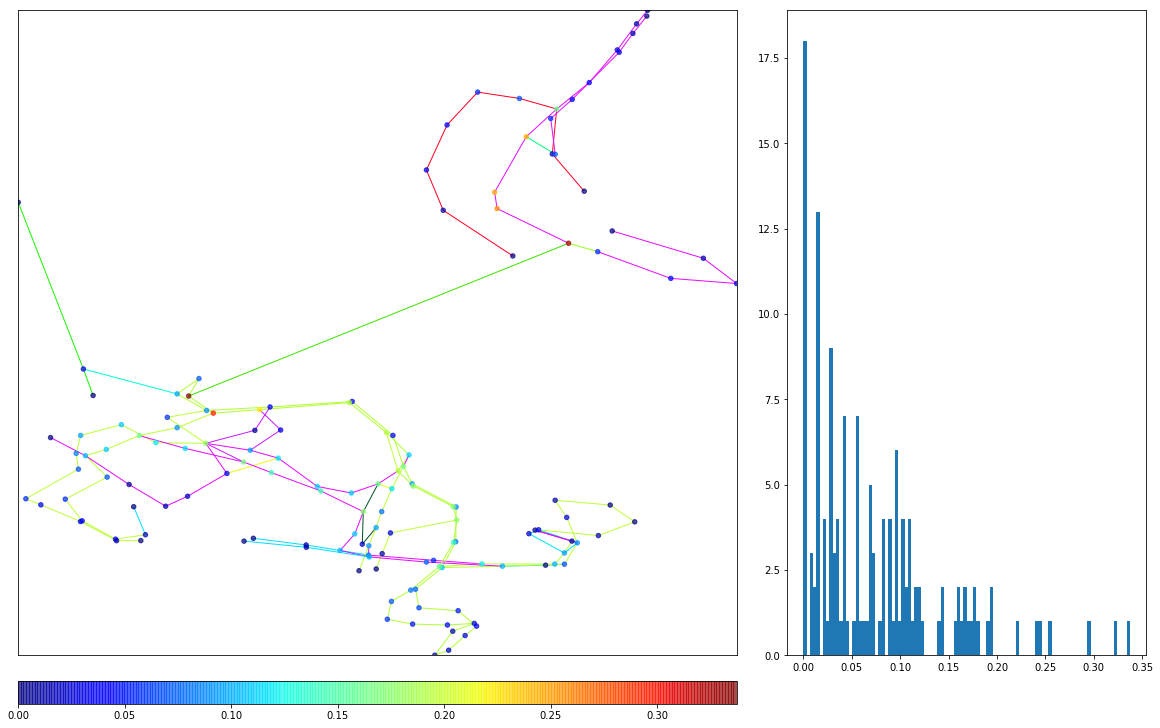

In [43]:
plot_gragh(Gr, load_centrality)
#plot_gragh(G, load_centrality)